## Atari Breakout Q-Learning

##### Allow memory growth for tensorflow, Windows work around

In [1]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

##### Verify GPU availability

In [2]:
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())
#from keras import backend as K
#print(K.tensorflow_backend._get_available_gpus())

#### Constants

In [3]:
IMG_HEIGHT=100
IMG_WIDTH=100

n_episodes = 1000

#### Training

In [4]:
import ai_display as display
import ai_util as util

def train(env, agent, n_episodes, img_pp, save_interval=10):
    for episode in range(n_episodes):
        frame = img_pp.preprocess(env.reset())
        state = util.create_state_arr(frame)
        score = 0
        
        for t in range(1000):
            frame_raw = env.render(mode='rgb_array')
            display.show_state(frame_raw, env.spec.id, t, score)

            action = agent.act(state)

            next_frame_raw, reward, done, info = env.step(action)
            next_frame = img_pp.preprocess(next_frame_raw)
            next_state = util.update_state_arr(state, next_frame)
            
            agent.remember(state, action, reward, next_state, done)
            
            state = next_state
            score += reward
            
            if done: 
                print("Episode {:>3}/{}, #frames {:>3}, score {}".format(episode+1, n_episodes, t, score))
                break
            
        agent.replay(batch_size=32)
        
        if episode % save_interval == 0:
            agent.save_model("model")
        

#### Main

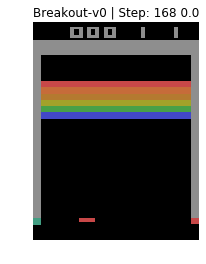

In [ ]:
from ai_agent import Agent
from ai_image_preprocess import ImagePreprocessor
import gym

#env = gym.make("BreakoutDeterministic-v4")
env = gym.make("Breakout-v0")
n_actions = env.action_space.n
state_shape = (IMG_WIDTH, IMG_HEIGHT, 4)

img_pp = ImagePreprocessor(IMG_WIDTH, IMG_HEIGHT)
agent = Agent(state_shape, n_actions)

#agent.new_model()
agent.load_model("model")
train(env, agent, n_episodes, img_pp, save_interval=10)
agent.save_model("model")